In [1]:
#look for enhancers from the ENCODE project
setwd("~/ben_lustre/current_projects/kidney_glomTI_response")
suppressPackageStartupMessages(source("https://raw.githubusercontent.com/bjstewart1/helpful_singlecell/main/functions.R"))
ad <- import("anndata")
sc <- import("scanpy")
sp <- import("scipy")
mu <- import("muon")
library(GenomicRanges)
library(Pando)
library(Signac)
library(zellkonverter)
library(GenomicRanges)
library(Pando)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(Signac)
library(Seurat)

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Registered S3 method overwritten by 'zellkonverter':
  method                from      
  py_to_r.numpy.ndarray reticulate

Loading required package: ensembldb

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

Loading required package: AnnotationFilter


Attaching package: 'ensembldb'


The following object is masked from 'package:stats':

    filter


Attaching SeuratObject


Attaching package: 'Seurat'


The following object is masked from 'package:SummarizedExperiment':

    Assays




In [2]:
library(liftOver)
library(rtracklayer)
path = file.path('./data/public_data/FANTOM/hg19ToHg38.over.chain')
ch = import.chain(path)
#these coordinates are quoted in weiterer et al. 2020 but they are unfortunately hg19 so we lift them over to hg38 :) 
CXC_coordinattes = liftOver(StringToGRanges('chr4-74400000-75400000'), ch)
CXC_coordinates = GRangesToString(CXC_coordinattes[[1]])

Loading required package: gwascat

gwascat loaded.  Use makeCurrentGwascat() to extract current image.

 from EBI.  The data folder of this package has some legacy extracts.

Loading required package: rtracklayer


Attaching package: 'rtracklayer'


The following object is masked from 'package:igraph':

    blocks


Loading required package: Homo.sapiens

Loading required package: OrganismDbi

Loading required package: GO.db



Loading required package: org.Hs.eg.db



Loading required package: TxDb.Hsapiens.UCSC.hg19.knownGene



In [3]:
#read in our sobj
sobj <- readRDS('./data/GRN/atac_sobj.RDS')

In [4]:
#get the genebodies of the subregions we want to plot
#now get the annotation
annotation = Annotation(sobj)
annotation = annotation[annotation$gene_name %in% c("CXCL8", "CXCL2"), ]
#get the gene bodies
annotation <- split(x = annotation,f = annotation$gene_name)
        #make a data frame with starts and finishes 
annotation_dfs = lapply(annotation, function(x){data.frame(start = min(start(x)),end = max(end(x)),seqname = data.frame(x@seqnames)[1,1],
                                                           gene_name = x$gene_name[[1]],type = "body")})
#bind together
annotation_dfs = do.call(rbind, annotation_dfs)
#into a granges object of gene bodies
genebodies = makeGRangesFromDataFrame(annotation_dfs)
gene_regions = Signac::Extend(genebodies, 20000, 20000)

Warning message in Signac::Extend(genebodies, 20000, 20000):
"'*' ranges were treated as '+'"


In [ ]:
#plot karyoplot chr 4
library(karyoploteR)
pdf("./figures/chr4_karyoplot.pdf")
kp <- plotKaryotype('hg38', chromosomes="chr4")
kpPlotRegions(kp, CXC_coordinates, col="#FFAACC")
dev.off()

In [5]:
#define a function to get a granges from bed
bed_to_granges <- function(file){
   df <- read.table(file,header=F,stringsAsFactors=F)
  if(length(df) > 6){
      df <- df[,-c(7:length(df))]}
   if(length(df)<3){
      stop("File has less than 3 columns")}
   header <- c('chr','start','end','id','score','strand')
   names(df) <- header[1:length(names(df))]
   if('strand' %in% colnames(df)){
      df$strand <- gsub(pattern="[^+-]+", replacement = '*', x = df$strand)}
   if(length(df)==3){
      gr <- with(df, GRanges(chr, IRanges(start, end)))} else if (length(df)==4){
      gr <- with(df, GRanges(chr, IRanges(start, end), id=id))} else if (length(df)==5){
      gr <- with(df, GRanges(chr, IRanges(start, end), id=id, score=score))} else if (length(df)==6){
      gr <- with(df, GRanges(chr, IRanges(start, end), id=id, score=score, strand=strand))}
   return(gr)
}

In [6]:
#get FANTOM enhancers 
fantom_enhancers = bed_to_granges("./data/public_data/FANTOM/human_permissive_enhancers_phase_1_and_2.bed")
#liftover to hg38
library(liftOver)
library(rtracklayer)
path = file.path('./data/public_data/FANTOM/hg19ToHg38.over.chain')
ch = import.chain(path)
seqlevelsStyle(fantom_enhancers) = "UCSC"  # necessary
fantom_enhancers_lift = liftOver(fantom_enhancers, ch)
fantom_enhancers_lift = unlist(fantom_enhancers_lift)
#flank 400 bp either side of the enhancer 
fantom_enhancers_lift = Signac::Extend(fantom_enhancers_lift, upstream = 100, downstream =100)
fantom_enhancers_lift$dataset = 'FANTOM'

Warning message in Signac::Extend(fantom_enhancers_lift, upstream = 100, downstream = 100):
"'*' ranges were treated as '+'"


In [7]:
#now get cCRE from ENCODE
encode_enhancers = import.bb("./data/public_data/ENCODE/ENCFF217ARC.bigBed")
#for the encode enhancers take the distal enhancers 
encode_enhancers = encode_enhancers[encode_enhancers$field11 == 'dELS', ]
encode_enhancers$dataset = 'ENCODE'

In [8]:
#but we can actually ge the encode enhancers from pando
library(Pando)
data('SCREEN.ccRE.UCSC.hg38')
table(SCREEN.ccRE.UCSC.hg38$class)
SCREEN.ccRE.UCSC.hg38$dataset = paste0("ENCODE", "_", SCREEN.ccRE.UCSC.hg38$class)


    CTCF-only,CTCF-bound                     dELS          dELS,CTCF-bound 
                   56766                   448981                   218618 
           DNase-H3K4me3 DNase-H3K4me3,CTCF-bound                     pELS 
                   16737                     8800                    64421 
         pELS,CTCF-bound                      PLS           PLS,CTCF-bound 
                   77409                     7582                    27221 

In [9]:
#get tfs in the gene regions
library(motifmatchr)
data(motifs) 
library(BSgenome.Hsapiens.UCSC.hg38)
motif_ranges <- matchMotifs(motifs, gene_regions, genome = BSgenome.Hsapiens.UCSC.hg38, bg = "genome",  out = "positions") 
motif_names = unlist(lapply(names(motifs@listData), function(x){motifs@listData[[x]]@name
}))
names(motif_names) = names(motifs@listData)
#use only ranges of TF we want
motif_ranges = motif_ranges[motif_names %in% c("NFKB1", "NFKB2", "RELA")]
names(motif_ranges)  = motif_names[names(motif_ranges)]
motif_ranges = makeGRangesFromDataFrame(do.call(rbind, lapply(names(motif_ranges), function(x){data.frame(motif_ranges[[x]], "dataset" = x)})), keep.extra.columns = T)

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: 'Biostrings'


The following object is masked from 'package:base':

    strsplit




In [10]:
#now we bind together the ranges we want to plot
motif_df = as.data.frame(motif_ranges)
fantom_df = as.data.frame(fantom_enhancers_lift)
encode_df = as.data.frame(SCREEN.ccRE.UCSC.hg38)
ranges_list = list(encode_df, fantom_df,motif_df)
cn = Reduce(intersect, lapply(ranges_list, colnames))
range_df = do.call(rbind, lapply(ranges_list, function(x){x[, cn]}))
ranges_use = makeGRangesFromDataFrame(range_df, keep.extra.columns = TRUE)

In [11]:
#get some bigwig tracks from the ENCODE projects - this gives us a sense of where promoters are..
bigwig_inventory = read.table("./data/public_data/ENCODE/bigwig_inventory.txt")
bigwig_inventory_list = lapply(1:nrow(bigwig_inventory), function(x){file.path("./data/public_data/ENCODE/bigwig_files", bigwig_inventory[x, 1])})
names(bigwig_inventory_list) = paste0(1:nrow(bigwig_inventory), "_", bigwig_inventory[, 2])

In [12]:
#read in cell type colors
ct_colors = readRDS( "data/annotated/celltype_colors.RDS")
ct_plot  =c('podocyte', 'GPEC', 'convoluted_PTEC', 'DTL_LOH', 'ATL_LOH', 
                   'cortical_TAL_LOH', 'DCT', 'IC_A', 'IC_B', 'PC', 'GEC', 'PCE', 'VRE', 'AE',
                  'cortical_fibroblast', 'MC', 'cortical_myofibroblast')

In [13]:
cxc_region = CoveragePlot(
  object = sobj,
  region = CXC_coordinates,
  annotation = TRUE,
  peaks = FALSE,
     extend.upstream = 0,
     extend.downstream = 0,
    show.bulk = TRUE,
    window = 2000,
    links = TRUE,
    region.highlight = gene_regions, 
        idents = ct_plot
) & scale_fill_manual(values= ct_colors)   


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


In [ ]:
#save the cxc region
cxc_region
pdf("./figures/cxc_region.pdf", width = 10, height = 10)
cxc_region
dev.off()

In [ ]:
#subplots
CoveragePlot(
  object = sobj,
  region = gene_regions[2],
  annotation = TRUE,
  peaks = FALSE,
     extend.upstream = 0,
     extend.downstream = 0,
    show.bulk = FALSE,
    window = 500,
    links = FALSE,
    ranges = ranges_use,
    ranges.group.by = 'dataset',
    bigwig = bigwig_inventory_list[c(8,9, 10)],
        idents = ct_plot
) & scale_fill_manual(values= ct_colors)   

In [ ]:
pdf("./figures/CXCL8zoom.pdf")
ct_colors = readRDS( "data/annotated/celltype_colors.RDS")
CoveragePlot(
  object = sobj,
  region = gene_regions[2],
  annotation = TRUE,
  peaks = FALSE,
     extend.upstream = 0,
     extend.downstream = 0,
    show.bulk = FALSE,
    window = 500,
    links = FALSE,
    ranges = ranges_use,
    ranges.group.by = 'dataset',
    bigwig = bigwig_inventory_list[c(8,9, 10)],
        idents = ct_plot
) & scale_fill_manual(values= ct_colors)   
dev.off()

In [ ]:
pdf("./figures/CXCL2zoom.pdf")
ct_colors = readRDS( "data/annotated/celltype_colors.RDS")
CoveragePlot(
  object = sobj,
  region = gene_regions[1],
  annotation = TRUE,
  peaks = FALSE,
     extend.upstream = 0,
     extend.downstream = 0,
    show.bulk = FALSE,
    window = 500,
    links = FALSE,
    ranges = ranges_use,
    ranges.group.by = 'dataset',
    bigwig = bigwig_inventory_list[c(8,9, 10)],
        idents = ct_plot
) & scale_fill_manual(values= ct_colors)   
dev.off()

In [ ]:
#subplots
CoveragePlot(
  object = sobj,
  region = 'NFKB1',
  annotation = TRUE,
  peaks = FALSE,
     extend.upstream = 20000,
     extend.downstream = 20000,
    show.bulk = FALSE,
    window = 500,
    links = FALSE,
    #ranges = ranges_use,
    #ranges.group.by = 'dataset',
    bigwig = bigwig_inventory_list[c(8,9, 10)],
        idents = ct_plot
) & scale_fill_manual(values= ct_colors)   

In [37]:
#catlas data
catlas_dir = "./data/public_data/catlas"
catlas_bigwigs = grep(".bw", file.path(catlas_dir, list.files(catlas_dir)), value = TRUE)
catlas_names = gsub(catlas_dir, "", catlas_bigwigs)
catlas_names = gsub(".bw","", catlas_names )
names(catlas_bigwigs) = catlas_names
catlas_bigwigs = as.list(catlas_bigwigs)

In [38]:
catlas_bigwigs

$`/A Cardiomyocyte`
[1] "./data/public_data/catlas/A Cardiomyocyte.bw"

$`/Adipocyte`
[1] "./data/public_data/catlas/Adipocyte.bw"

$`/Alveolar Cap Endo`
[1] "./data/public_data/catlas/Alveolar Cap Endo.bw"

$`/BBB Endothelial`
[1] "./data/public_data/catlas/BBB Endothelial.bw"

$`/Cilliated`
[1] "./data/public_data/catlas/Cilliated.bw"

$`/Colon Epithelial 1`
[1] "./data/public_data/catlas/Colon Epithelial 1.bw"

$`/Colon Epithelial 2`
[1] "./data/public_data/catlas/Colon Epithelial 2.bw"

$`/Colon Epithelial 3`
[1] "./data/public_data/catlas/Colon Epithelial 3.bw"

$`/Endothelial General 1`
[1] "./data/public_data/catlas/Endothelial General 1.bw"

$`/Endothelial General 2`
[1] "./data/public_data/catlas/Endothelial General 2.bw"

$`/Endothelial General 3`
[1] "./data/public_data/catlas/Endothelial General 3.bw"

$`/Endothelial Myocardial`
[1] "./data/public_data/catlas/Endothelial Myocardial.bw"

$`/Lymphatic`
[1] "./data/public_data/catlas/Lymphatic.bw"

$`/Macrophage General`
[1] "./data/public_data/catlas/Macrophage General.bw"

$`/Melanocyte`
[1] "./data/public_data/catlas/Melanocyte.bw"

$`/Microglia`
[1] "./data/public_data/catlas/Microglia.bw"

$`/Vasc Sm Muscle 1`
[1] "./data/public_data/catlas/Vasc Sm Muscle 1.bw"

$`/Vasc Sm Muscle 2`
[1] "./data/public_data/catlas/Vasc Sm Muscle 2.bw"

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


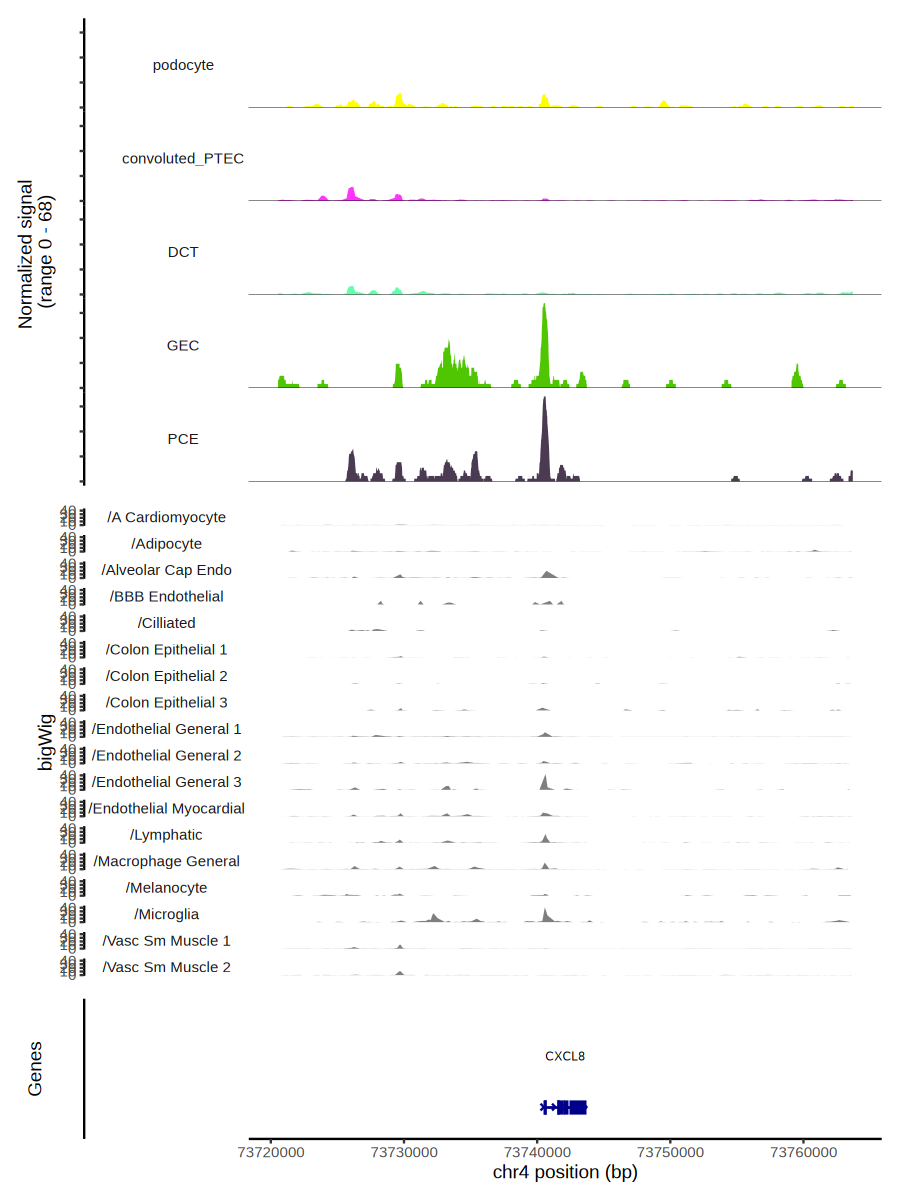

In [39]:
#subplots
options(repr.plot.width = 7.5, repr.plot.height = 10)
CoveragePlot(
  object = sobj,
  region = gene_regions[2],
  annotation = TRUE,
  peaks = FALSE,
     extend.upstream = 0,
     extend.downstream = 0,
    show.bulk = FALSE,
    window = 500,
    links = FALSE,
    bigwig = catlas_bigwigs,
    bigwig.scale = 'common',
        idents = c("GEC", "convoluted_PTEC", "podocyte", 'DCT', 'PCE')
) & scale_fill_manual(values= ct_colors)   